## **Inference Pipeline**
This notebook will be used to test the model performance and test results

In [1]:
import sys
sys.path.append("/home/jupyter-group3/reconstruction/reconstruction-deep-network")

In [2]:
import numpy as np
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from argparse import ArgumentParser
import yaml
import re
import itertools
import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict
from tqdm import tqdm

import reconstruction_deep_network
from reconstruction_deep_network.data_loader.custom_loader import CustomDataLoader
from reconstruction_deep_network.trainer.trainer import ModelTrainer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.set_float32_matmul_precision('medium')

In [3]:
def find_checkpoint_files(directory, match_string):
    checkpoint_files = []
    pattern = re.compile(match_string)

    for filename in os.listdir(directory):
        
        if pattern.search(filename):
            checkpoint_files.append(os.path.join(directory, filename))

    return checkpoint_files

def show_images(images, n_views=4):
    n_images = images.shape[0]
    assert n_images == n_views
    original_images = (images + 1) * 127.5
    original_images = np.clip(original_images, 0, 255).astype(np.uint8)
    n_rows = 2
    n_cols = n_views//2 
    if n_views > 2:
        prods = list(itertools.product(range(n_rows), range(n_cols)))
    else:
        prods = [0, 1]
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(11, 5))
    for itr, ij in enumerate(prods):
        axs[ij].imshow((original_images[itr]))
    
    plt.tight_layout()
    plt.show()

def create_batch(data_dict, device = "cpu"):
    batched_keys = ["images", "text_embedding", "img_encoding", "R", "K"]
    num_views = data_dict["images"].shape[0] 
    
    
    for key in data_dict:
        if key in batched_keys:
            data_dict[key] = torch.from_numpy(np.expand_dims(data_dict[key], 0)).to(device)    
    
    return data_dict

@torch.no_grad()
def class_free_guidance_pair(latents, timestep, prompt_embed, R, K):
    latents = torch.cat([latents] * 2)
    timestep = torch.cat([timestep] * 2)

    R = torch.cat([R] * 2)
    K = torch.cat([K] * 2)

    meta = {
        "K": K,
        "R": R
    }

    return latents, timestep, prompt_embed, meta

@torch.no_grad()
def forward_class_free(latents_high_res, timestep, prompt_embed, R, K, model):
    
    latents, timestep, prompt_embed, meta = class_free_guidance_pair(
        latents_high_res, timestep, prompt_embed, R, K
    )
    print(timestep.device)
    noise_pred = model(latents, timestep, prompt_embed, meta)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 9 * \
        (noise_pred_text - noise_pred_uncond)

    return noise_pred

@torch.no_grad()
def inference_latent_prediction(model_trainer, prompt_embedding, R, K, device):
    m = 8
    height = 512
    width = 512
    to_torch = lambda x: torch.from_numpy(np.expand_dims(x, 0)).to(device)
    prompt_embedding = to_torch(prompt_embedding)
    R = to_torch(R)
    K = to_torch(K)
    latents = torch.randn(
            1, m, 4, height//8, width//8, device=device)
    
    null_embedding = model_trainer.load_null_embedding()
    null_embedding = null_embedding[:, None].repeat(1, m, 1, 1).to(device)        
    complete_embedding = torch.cat([null_embedding, prompt_embedding])
    
    
    model_trainer.scheduler.set_timesteps(50, device = device)
    timesteps = model_trainer.scheduler.timesteps
    
    for i, t in enumerate(tqdm(timesteps)):        
        _timestep = torch.cat([t[None, None]]*m, dim=1)

        noise_pred = forward_class_free(
            latents, _timestep, complete_embedding, R, K, model_trainer.mv_base_model)

        latents = self.scheduler.step(
            noise_pred, t, latents).prev_sample
    
    return latents
    
def create_ordered_dict(state_dict):
    
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("mv_base_model.unet.", "") # remove `module.`
        new_state_dict[name] = v
    
    return new_state_dict
    
    

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
torch.cuda.empty_cache()

In [6]:
module_dir = reconstruction_deep_network.__path__[0]
notebooks_dir = os.path.join(module_dir, "notebooks", "pipelines")
lightning_logs = os.path.join(notebooks_dir, "lightning_logs")
model_version = input("Enter model version")
model_dir = os.path.join(lightning_logs, f"version_{model_version}", "checkpoints")

checkpoint_files = find_checkpoint_files(model_dir, r"epoch=")

Enter model version 74


In [7]:
checkpoint_files[0]

'/home/jupyter-group3/reconstruction/reconstruction-deep-network/reconstruction_deep_network/notebooks/pipelines/lightning_logs/version_74/checkpoints/epoch=epoch=12-loss=train_loss=0.0040.ckpt'

In [8]:

device = torch.device('cpu')
# unet_model = torch.load(checkpoint_files[0], map_location='cpu')["state_dict"]
# unet_model = create_ordered_dict(unet_model)
model_trainer = ModelTrainer()
model_trainer.load_state_dict(torch.load(checkpoint_files[0], map_location='cuda')[
            'state_dict'], strict=False)

Loading image encoders...
Loading diffusion models...


<All keys matched successfully>

In [9]:
# # load VAE
# model_version = input("Enter model version")
# model_dir = os.path.join(lightning_logs, f"version_{model_version}", "checkpoints")

# checkpoint_files = find_checkpoint_files(model_dir, r"epoch=")

In [10]:
checkpoint_files[0]

'/home/jupyter-group3/reconstruction/reconstruction-deep-network/reconstruction_deep_network/notebooks/pipelines/lightning_logs/version_74/checkpoints/epoch=epoch=12-loss=train_loss=0.0040.ckpt'

In [11]:
# trained_model = torch.load(checkpoint_files[0], map_location='cpu')["state_dict"]
# vae_state_dict = OrderedDict()

# for k, v in trained_model.items():
#     if k.startswith("vae"):
#         name = k.replace("vae.", "")
#         vae_state_dict[name] = v

# model_trainer.vae.load_state_dict(vae_state_dict, strict=False)

In [55]:
model_trainer.diffusion_timestep = 500

In [13]:
for down_block in model_trainer.mv_base_model.unet.down_blocks:
    if hasattr(down_block, 'has_cross_attention') and down_block.has_cross_attention:
        down_block.has_cross_attention = False
    
    
for up_block in model_trainer.mv_base_model.unet.up_blocks:
    if hasattr(up_block, 'has_cross_attention') and up_block.has_cross_attention:
        up_block.has_cross_attention = False

In [14]:
for param_name, param in model_trainer.mv_base_model.unet.named_parameters():
    print(f'{param_name}: {param.requires_grad}')
    break

conv_in.weight: True


In [15]:
## load validation dataset
val_metadata = "ir-20231129-train-split"
num_views = 1
val_dataset = CustomDataLoader(mode = "train",
                               debug = False,
                               metadata_filename = val_metadata,
                               num_views = num_views)

In [16]:
rand_index = np.random.randint(0, len(val_dataset))
data_dict = val_dataset[1000]
images = data_dict["images"]

# show_images(images, num_views)

In [17]:
results_dir = os.path.join(module_dir, "notebooks", "pipelines", "results")
if os.path.isdir(results_dir):
    print("Result directory exists")

Result directory exists


In [18]:
model_trainer.mv_base_model.unet.to("cuda")
model_trainer.vae.to("cuda")

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv

In [19]:
# # predicted_latents = inference_latent_prediction(model_trainer, data_dict["text_embedding"], data_dict["R"], data_dict["K"], device)
# for itr, data_dict in enumerate(val_dataset):
    
    
#     pseudo_batch = create_batch(data_dict, "cuda")
#     images_pred = model_trainer.inference(pseudo_batch)
    
# #     predicted_latents = predicted_latents.to("cuda:0")
# #     print(predicted_latents.shape)
# #     images_pred = model_trainer.decode_latent(predicted_latents, model_trainer.vae)
#     images_pred = images_pred.cpu().numpy().squeeze()
    
# #     img_path = data_dict["images_paths"][0].split("/")
# #     scan_id = img_path[0]
# #     img_name = img_path[-1].split("_")[0]
    
# #     file_name = os.path.join(results_dir, f"{scan_id}_{img_name}.npz")
# #     np.savez_compressed(file_name, predictions=images_pred)
    
# #     del predicted_latents, images_pred
#     if (itr + 2) % 1 == 0:
#         print("Prediction generation done")
#         break
    
    

In [56]:
# 1350 3000 1310 
val_list = [1300, 1310, 1350, 3000, 1399, 1400, 1599]
pred_list = []
for val_idx in tqdm(val_list):
    data_dict = val_dataset[val_idx]
    pseudo_batch = create_batch(data_dict, "cuda")
    images_pred = model_trainer.inference(pseudo_batch)
    break
    pred_list.append(images_pred)

  0%|          | 0/7 [00:27<?, ?it/s]


In [45]:
images_pred.shape

torch.Size([1, 1, 512, 512, 3])

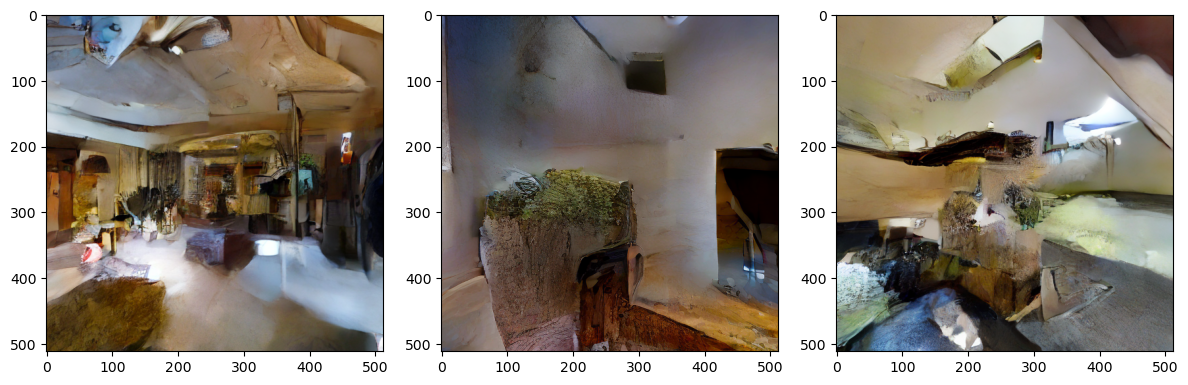

In [50]:
images_to_plot = [pred_list[1], pred_list[2], pred_list[3]]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (12, 5))

grid_list = [[0, 0], [0, 1], [0, 2]]
for itr, ij in enumerate(grid_list):
    image = images_to_plot[itr].cpu().numpy().squeeze()
    axs[itr].imshow(image)
    break
    
fig.tight_layout()
plt.show()

In [39]:
axs[0, 0]

<AxesSubplot:>

In [ ]:
plt.figure(figsize = (10, 5))
plt.imshow(images_pred.cpu().numpy().squeeze())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


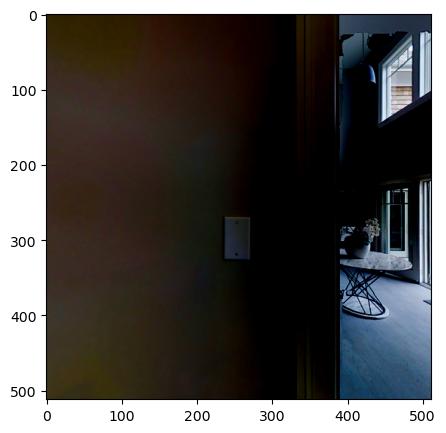

In [28]:
# show_images(data_dict["images"].cpu().numpy().squeeze(), 1)
plt.figure(figsize = (10, 5))
plt.imshow(data_dict["images"].cpu().numpy().squeeze())
plt.show()

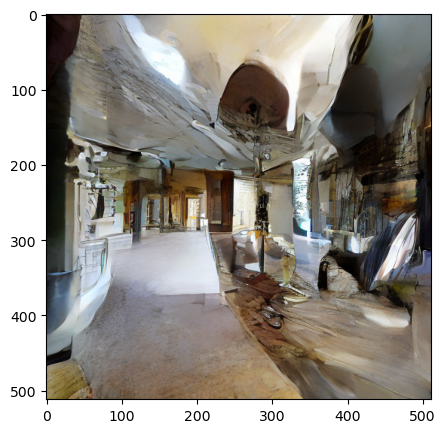

Text(0.5, 1.0, 'Runtime Analysis')

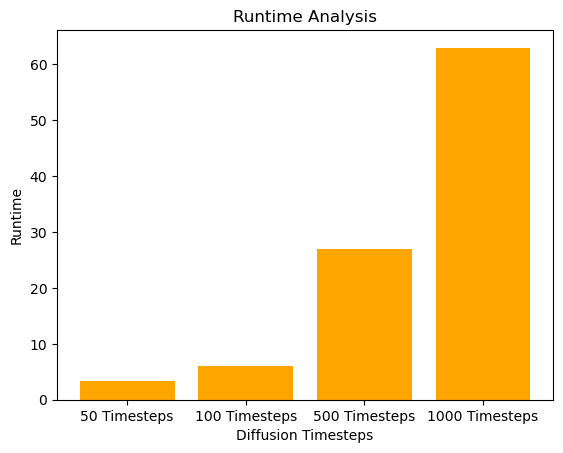

In [60]:
# Sample data
categories = ['50 Timesteps', '100 Timesteps', '500 Timesteps', '1000 Timesteps']
values = [3.3, 6, 27, 63]

# Create a bar plot
plt.bar(categories, values, color='orange')

# Add labels and title
plt.xlabel('Diffusion Timesteps')
plt.ylabel('Runtime')
plt.title('Runtime Analysis')

In [33]:
data_dict["prompt"]

['This is one view of a scene. a kitchen with a table and chairs in it']

In [25]:
# load npz file
file_list = os.listdir(results_dir)
file_name = file_list[7]
file_path = os.path.join(results_dir, file_name)
image_arr = np.load(file_path)["predictions"]
image_arr.shape

(8, 512, 512, 3)

In [26]:
image_arr = image_arr

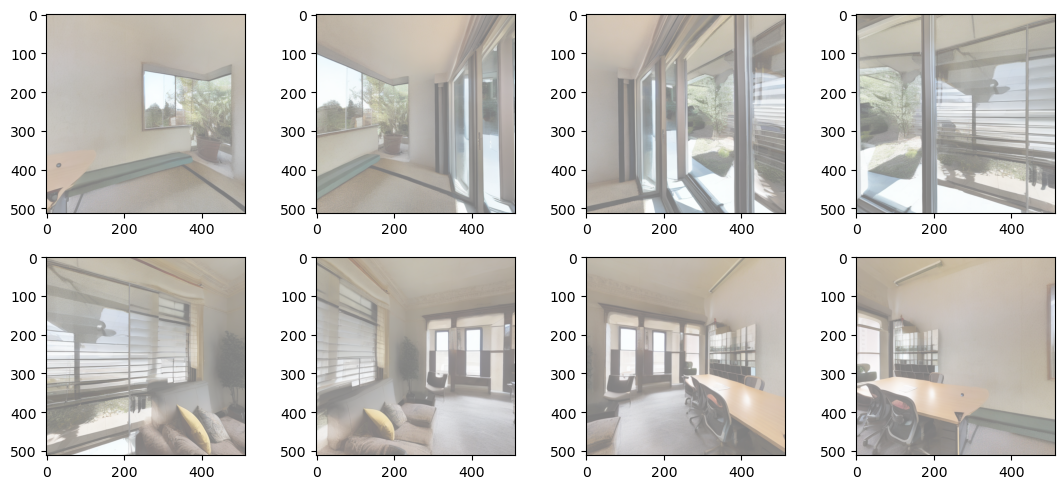

In [27]:
show_images(image_arr, 8)

In [28]:
file_name

'1LXtFkjw3qL_03a8325e3b054e3fad7e1e7091f9d283.npz'

In [37]:
val_dataset[6]["prompt"]

['This is one view of a scene. a window with a view of the outside',
 'This is one view of a scene. a living room with a couch and a fireplace',
 'This is one view of a scene. a living room with a couch and a fireplace',
 'This is one view of a scene. a living room with a large couch and a flat screen tv',
 'This is one view of a scene. a living room with a couch and a table',
 'This is one view of a scene. a bedroom with a large bed and a glass wall',
 'This is one view of a scene. a room with a bed and a window',
 'This is one view of a scene. a bedroom with a large bed and a large window']

In [17]:
!nvidia-smi

Mon Dec  4 17:42:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   39C    P0    41W / 250W |   2797MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:00:07.0 Off |                    0 |
| N/A   

In [18]:
!kill 1124

/bin/bash: line 0: kill: (1124) - No such process


## **TODO: Error analysis with decoder**
Check whether the autoencoder can actually decode the latents. 

In [19]:
import torch.nn as nn
m = nn.Linear(192, 10)
input = torch.randn(2, 197, 192)
output = m(input)
print(output.size())

torch.Size([2, 197, 10])


In [20]:
flatten = nn.Flatten(1)
x = torch.randn(1, 1024, 8, 8)
op = flatten(x)
op.size()

torch.Size([1, 65536])